# Demo: Horse

This notebook demonstrates how the noisy minimum spanning tree union ($n$-MST) and $k$-nearest minimum spanning tree ($k$-MST) behave on a horse-shaped mesh-reconstruction dataset [[1]](https://dl.acm.org/doi/10.1145/1015706.1015736). The dataset is characterized by large variations in density corresponding to local level of details. Our goal is to find a graph with a single connected component that describes the horse's structure. Compute times and the Sortedness [[2]](https://diglib.eg.org/handle/10.2312/eurova20231093) of the networks' SFDP  layouts [[3]](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=be33ebd01f336c04a1db20830576612ab45b1b9b) are computed to demonstrate feasability as dimensionality reduction approach.

In [1]:
import pandas as pd
from umap import UMAP

import warnings
from numba import NumbaPendingDeprecationWarning
# UMAP warns when spectral initialisation fails or points are not connected
warnings.filterwarnings("ignore", category=UserWarning)
# UMAP / PYNNDescent not yet updated for recent numba versions
warnings.filterwarnings("ignore", category=NumbaPendingDeprecationWarning)

from multi_mst.k_mst import KMST
from multi_mst.noisy_mst import NoisyMST
from multi_mst.k_mst_descent import KMSTDescent
from lib.drawing import draw_graph, draw_umap, draw_force, compute_force

The data [[1]](https://dl.acm.org/doi/10.1145/1015706.1015736) is loaded from a local file and contains x, y, and z coordinates.

In [2]:
df = pd.read_csv('./data/horse/horse.csv')
df.shape

(8431, 3)

### UMAP

UMAP is used to demonstrate $k$-nearest neighbour network ($k$-NN) approaches on this dataset. Notice how at low values of $k$ many separate components are detected. At higher values of $k$ a single component emerges, but local details start to disappear.

In [3]:
def run_umap(k):
    p = UMAP(
        n_neighbors=k, 
        init='random' if k == 3 else 'spectral',
        repulsion_strength=1 if k < 10 else 0.2,
    ).fit(df)
    draw_umap(p, color=df.z, name='horse', alg=f'umap_{k}')
    draw_force(p, color=df.z, name='horse', alg=f'umap_{k}')
    draw_graph(p, df.z, df.y, color=df.z, name='horse', alg=f'umap_{k}')

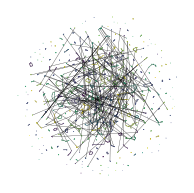

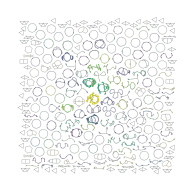

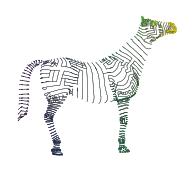

In [4]:
run_umap(3)

In [8]:
%%timeit
p = UMAP(n_neighbors=3, transform_mode='graph').fit(df)

63.5 ms ± 270 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


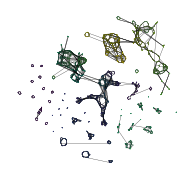

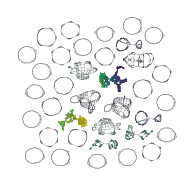

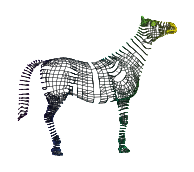

In [5]:
run_umap(5)

In [9]:
%%timeit
p = UMAP(n_neighbors=5, transform_mode='graph').fit(df)

63.9 ms ± 610 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


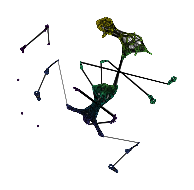

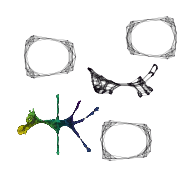

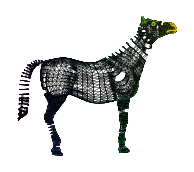

In [6]:
run_umap(10)

In [10]:
%%timeit
p = UMAP(n_neighbors=10, transform_mode='graph').fit(df)

81.4 ms ± 1.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### $k$-MST

The $k$-MST captures global connectivity at low values of $k$ and results in small models:

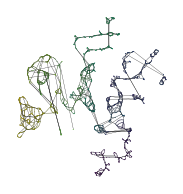

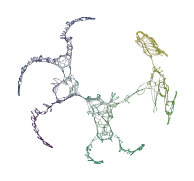

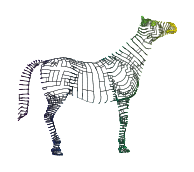

In [11]:
p = KMST(num_neighbors=3).fit(df)
draw_umap(p, color=df.z, name='horse', alg=f'kmst_3')
draw_force(p, color=df.z, name='horse', alg=f'kmst_3')
draw_graph(p, df.z, df.y, color=df.z, name='horse', alg=f'kmst_3')

In [12]:
%%timeit
p = KMST(num_neighbors=3, umap_kwargs=dict(transform_mode='graph')).fit(df)

37.5 ms ± 997 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Approximate $k$-MST

An approximate $k$-MST version is quicker on datasets with many dimensions, not neccesarily this dataset.

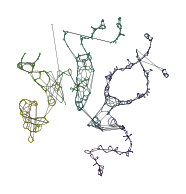

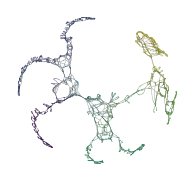

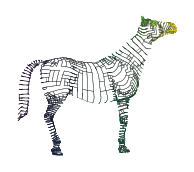

In [13]:
p = KMSTDescent(num_neighbors=3).fit(df)
draw_umap(p, color=df.z, name='horse', alg=f'kmst_descent_3')
draw_force(p, color=df.z, name='horse', alg=f'kmst_descent_3')
draw_graph(p, df.z, df.y, color=df.z, name='horse', alg=f'kmst_descent_3')

In [14]:
%%timeit
p = KMSTDescent(num_neighbors=3, umap_kwargs=dict(transform_mode='graph')).fit(df)

386 ms ± 11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Noisy MST

The $n$-MST behaves similarly!

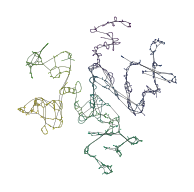

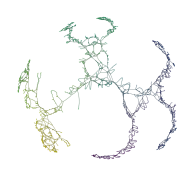

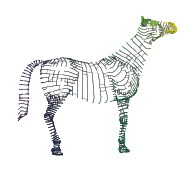

In [15]:
p = NoisyMST(num_trees=3, noise_fraction=0.6).fit(df)
draw_umap(p, color=df.z, name='horse', alg=f'nmst_3')
draw_force(p, color=df.z, name='horse', alg=f'nmst_3')
draw_graph(p, df.z, df.y, color=df.z, name='horse', alg=f'nmst_3')

In [16]:
%%timeit
p = NoisyMST(num_trees=3, noise_fraction=0.6, umap_kwargs=dict(transform_mode='graph')).fit(df)

163 ms ± 1.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Sortedness

It is difficult to measure the quality of a manifold approximation graph without a ground truth manifold. If the main goal is visualising data, dimensionality reduction quality metrics can be used to quantify how well a 2D layout matches high dimensional data. Here, we compute a sortedness metric [[2]](https://diglib.eg.org/handle/10.2312/eurova20231093) to compare SFDP [[3]](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=be33ebd01f336c04a1db20830576612ab45b1b9b) layouts for $k$-NNs and $k$-MSTs.

In [10]:
import numba
import numpy as np
from tqdm import tqdm
from scipy.stats import weightedtau
from scipy.spatial.distance import cdist


@numba.njit(parallel=True)
def rank_along_col(orders):
    """Convert per-row argsort order into ranks."""
    out = np.empty(orders.shape, dtype=np.intp)
    for row in numba.prange(orders.shape[0]):
        for i, o in enumerate(orders[row, :]):
            out[row, o] = i
    return out


def score_ranks(a, b):
    """Computes Sortedness from data ranks (a) and embedding ranks (b)."""
    sortedness = np.empty(a.shape[0], dtype=np.float32)
    for idx in range(a.shape[0]):
        sortedness[idx] = weightedtau(a[idx, :], b[idx, :], rank=a[idx, :]).statistic
    return np.mean(sortedness)

In [13]:
results = []
dissimilarities = cdist(df, df, metric="euclidean")
dissimilarity_order = np.argsort(dissimilarities, axis=1)
dissimilarity_ranks = rank_along_col(dissimilarity_order)

def compute_sortedness(algorithm='umap', n_neighbors=3):
    """Runs algorithm, computes SFDP layout, computes sortedness."""
    if algorithm == 'umap':
        p = UMAP(n_neighbors=n_neighbors, transform_mode='graph').fit(df)
    else:
        p = KMST(num_neighbors=n_neighbors, transform_mode='graph').fit(df)
    
    X = compute_force(p)
    
    distances = cdist(X, X, metric="sqeuclidean")
    distance_order = np.argsort(distances, axis=1)
    distance_ranks = rank_along_col(distance_order)
    
    sortedness = score_ranks(dissimilarity_ranks, distance_ranks)
    return dict(algorithm=algorithm, n_neighbors=k, sortedness=sortedness)

for _ in tqdm(range(3)):
    for k in [2, 3, 4, 5, 10]:   
        results.append(compute_sortedness(algorithm='umap', n_neighbors=k))
        results.append(compute_sortedness(algorithm='kmst', n_neighbors=k))

100%|██████████| 3/3 [43:50<00:00, 876.88s/it]


The cell below shows the average sortedness over $3$ runs. We note that $k$-MST has a high (>0.87) sortedness starting from $k=2$ while the $k$-NN needs $k=10$ to reach that level. This pattern indicates that the $k$-MST can be more selective in the short connectivity it captures while retaining the global structure.

In [14]:
values = pd.DataFrame(results)
values.groupby(by=['algorithm','n_neighbors']).agg({'sortedness': ['mean', 'std']})

sortedness          
                            mean       std
algorithm n_neighbors                     
kmst      2             0.873898  0.000000
          3             0.895666  0.000000
          4             0.895313  0.000000
          5             0.899422  0.000000
          10            0.905662  0.000000
umap      2             0.222957  0.001704
          3             0.404570  0.009626
          4             0.609819  0.005274
          5             0.722049  0.010728
          10            0.887574  0.014591